In [1]:
# 決定木　これも回帰/分類両方が可能なアルゴリズム
# To support both python 2 and python 3
# お決まりのセットアップ
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [2]:
# irisデータで決定木の訓練を行ってみる　
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width がくの情報を使わず花弁情報のみ抽出
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42) # クラス設定
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [17]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

In [19]:
# 作成されたdotファイルをpngに変換して出力するコマンド(該当フォルダに移動してください)
# dot -Tpng iris_tree.dot -o iris_tree.png
# C:\Users\leuyx\git\ml\06_Decision_trees\images\decision_trees
# samples:当ノードの処理数　例:50
# value:そのノードにいくつインスタンスがあてはまったか 例:[50,0,0] 
# class:分類結果
# gini係数:ノードの不純度 0が純粋(一つのクラスしかあてはまらない)
# gini係数は不純度の指標になるため決定木のハイパーパラメータ調整に役立つ

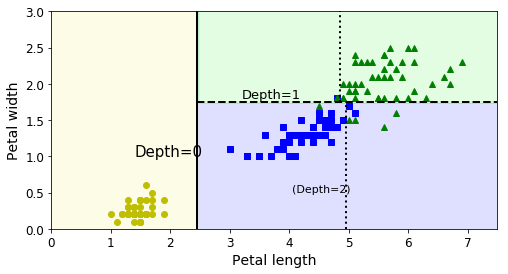

In [27]:
# 決定境界をグラフにしてみる
# パラメータのDepth追加により決定境界が追加されていく様子をグラフ化する
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.savefig("decision_tree_decision_boundaries_plot")
plt.show()

# Depth 0: Petal length 2.45 で分割される。この時点で線の右側はGini係数は純粋(0)になる
# Depth 1: Petal width 1.75 で分割される。max depth が2の場合はこれで終了
# Depth 2: Peta length 4.xx で分割される。これによりより精度が高くなっている

In [28]:
# クラスの確率の推計を出したい場合
# predict_probaメソッドで各クラスに出力される確率を出すことができる
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [29]:
# 上記が実際にどのクラスに分類されたかを見てみる
tree_clf.predict([[5, 1.5]])

array([1])

In [30]:
# CART訓練アルゴリズム:決定木のアルゴリズム。データセットをサイズと不純度を測定しで最も純粋なサブセットに分割していくことを繰り返す
# この方法ではトップレベルで純度が優先されるため、数レベル降りた先の不純度が最低になるかまでは見ていない。最適解保証はないということ

In [ ]:
# 計算量: 小さな訓練セットの場合はpresort=true のパラメータで訓練高速化が可能だが、大きいとかなり遅くなる

In [ ]:
# ジニ不純度かエントロピーか:criterionハイパーパラメータで選択できるが基本どちらでもいい
# 若干ジニ不純度の方が高速。エントロピーの方が平衡のとれた木を作る傾向がある。でも気にするレベルじゃなさそう

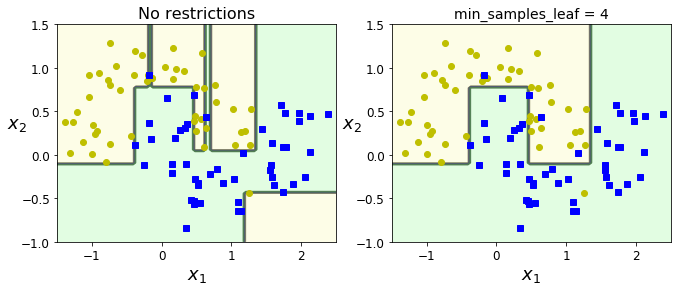

In [32]:
# 正則化ハイパーパラメータ
# 決定木は訓練データに密接に適合するため、過学習しやすい。
# 線形モデルはできることが限られているためパラメータも少なく過少適合するが過学習しにくい
# 過学習を防ぐため、決定木では　正則化が重要となる
# Max Depth:木構造の深度を設定(Noneで無制限)　一番効果が大きいパラメータ 
# min_sample_leaf:ノードを分割するためのサンプルの下限
# min_weicht_fraction_leaf:重みをもつインスタンスの総数の割合
# max_leaf_nodes:葉ノードの上限
# max_featutes:各ノードで分割するために評価される特徴量数の上限

# 上記のmax/min　で正則化を行う

from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42) # 正則化なし
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42) # 正則化あり
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.savefig("min_samples_leaf_plot")
plt.show()

# 左は正則化なし。過学習している
# 右はmin_samples_leaf = 4 の正則化あり。汎化性能が高いものが出来上がっている
#